In [40]:
import pandas as pd
import numpy as np
import json
import zipfile
import os
import math
from collections import Counter
from typing import Tuple, Dict, List
import matplotlib.pyplot as plt
import seaborn as sns
from itertools import combinations
from collections import Counter
import random

#### CHANGE THE VALUES IN THE CELL BELOW
##### It should correspond to the amount of .json files you want to read and the filepath were your archive.zip folder is that you downloaded from kaggle at the following link (https://www.kaggle.com/datasets/himanshuwagh/spotify-million/data)
##### **DO NOT EXCTRACT THE DATA, THE SCRIPT READS DIRECTLY FROM THE ZIP FOLDER**

In [9]:
#CHANGE THE VALUES HERE

amount_of_json_files_to_read = 3
zip_path = "C:/Users/Clara/Downloads/archive.zip"
os.chdir("C:/Users/Clara/Downloads")

In [10]:
with open('spotify-million-metadata.json', 'r') as f:
    data = json.load(f)

In [11]:
playlist_rows = []
track_rows = []
file_rows = []


In [12]:
with zipfile.ZipFile(zip_path, 'r') as z:
    json_files = [f for f in z.namelist() if f.startswith("data/") and f.endswith(".json")]
    json_files.sort()
    
    for filename in json_files[:amount_of_json_files_to_read]:
        print(f"Reading {filename}...")
        with z.open(filename) as f:
            parsed = json.loads(f.read().decode("utf-8"))
            
            #metadata for file
            info = parsed.get("info", {})
            file_rows.append({
                "filename": filename,
                **info
            })
            
            #metadata playlist
            for pl in parsed["playlists"]:
                unique_artists = len({t["artist_name"] for t in pl["tracks"]})
                playlist_entry = {**pl}
                playlist_entry["num_artists"] = unique_artists
                playlist_entry["filename"] = filename
                playlist_rows.append(playlist_entry)
                
                #track metadata
                for track in pl["tracks"]:
                    track_entry = {**track}
                    track_entry["pid"] = pl.get("pid")
                    track_entry["filename"] = filename
                    track_rows.append(track_entry)


Reading data/mpd.slice.0-999.json...
Reading data/mpd.slice.1000-1999.json...
Reading data/mpd.slice.10000-10999.json...


In [13]:
df_playlists = pd.DataFrame(playlist_rows)
df_tracks = pd.DataFrame(track_rows)
df_files = pd.DataFrame(file_rows)

In [14]:
#df_full = df_tracks_playlists.merge(df_files, on="filename")
df_full= df_playlists.drop(columns = ["tracks"]).merge(df_tracks, on=["pid", "filename"], suffixes=("_playlist", "_track"))
df_full["track_id"] = df_full["track_uri"].str.split(":").str[-1]
df_full.head()

,name,collaborative,pid,modified_at,num_tracks,num_albums,num_followers,num_edits,duration_ms_playlist,num_artists,...,description,pos,artist_name,track_uri,artist_uri,track_name,album_uri,duration_ms_track,album_name,track_id
0,Throwbacks,false,0,1493424000,52,47,1,6,11532414,37,...,NaN,0,Missy Elliott,spotify:track:0UaMYEvWZi0ZqiDOoHU3YI,spotify:artist:2wIVse2owClT7go1WT98tk,Lose Control (feat. Ciara & Fat Man Scoop),spotify:album:6vV5UrXcfyQD1wu4Qo2I9K,226863,The Cookbook,0UaMYEvWZi0ZqiDOoHU3YI
1,Throwbacks,false,0,1493424000,52,47,1,6,11532414,37,...,NaN,1,Britney Spears,spotify:track:6I9VzXrHxO9rA9A5euc8Ak,spotify:artist:26dSoYclwsYLMAKD3tpOr4,Toxic,spotify:album:0z7pVBGOD7HCIB7S8eLkLI,198800,In The Zone,6I9VzXrHxO9rA9A5euc8Ak
2,Throwbacks,false,0,1493424000,52,47,1,6,11532414,37,...,NaN,2,Beyoncé,spotify:track:0WqIKmW4BTrj3eJFmnCKMv,spotify:artist:6vWDO969PvNqNYHIOW5v0m,Crazy In Love,spotify:album:25hVFAxTlDvXbx2X2QkUkE,235933,Dangerously In Love (Alben für die Ewigkeit),0WqIKmW4BTrj3eJFmnCKMv
3,Throwbacks,false,0,1493424000,52,47,1,6,11532414,37,...,NaN,3,Justin Timberlake,spotify:track:1AWQoqb9bSvzTjaLralEkT,spotify:artist:31TPClRtHm23RisEBtV3X7,Rock Your Body,spotify:album:6QPkyl04rXwTGlGlcYaRoW,267266,Justified,1AWQoqb9bSvzTjaLralEkT
4,Throwbacks,false,0,1493424000,52,47,1,6,11532414,37,...,NaN,4,Shaggy,spotify:track:1lzr43nnXAijIGYnCT8M8H,spotify:artist:5EvFsr3kj42KNv97ZEnqij,It Wasn't Me,spotify:album:6NmFmPX56pcLBOFMhIiKvF,227600,Hot Shot,1lzr43nnXAijIGYnCT8M8H


In [15]:
print(df_full.shape[0] == df_playlists["num_tracks"].sum()) #dq OK

True


In [16]:
kaggle = pd.read_csv("spotify_data.csv")
kaggle.head()

,Unnamed: 0,artist_name,track_name,track_id,popularity,year,genre,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,time_signature
0,0,Jason Mraz,I Won't Give Up,53QF56cjZA9RTuuMZDrSA6,68,2012,acoustic,0.483,0.303,4,-10.058,1,0.0429,0.6940,0.000000,0.1150,0.139,133.406,240166,3
1,1,Jason Mraz,93 Million Miles,1s8tP3jP4GZcyHDsjvw218,50,2012,acoustic,0.572,0.454,3,-10.286,1,0.0258,0.4770,0.000014,0.0974,0.515,140.182,216387,4
2,2,Joshua Hyslop,Do Not Let Me Go,7BRCa8MPiyuvr2VU3O9W0F,57,2012,acoustic,0.409,0.234,3,-13.711,1,0.0323,0.3380,0.000050,0.0895,0.145,139.832,158960,4
3,3,Boyce Avenue,Fast Car,63wsZUhUZLlh1OsyrZq7sz,58,2012,acoustic,0.392,0.251,10,-9.845,1,0.0363,0.8070,0.000000,0.0797,0.508,204.961,304293,4
4,4,Andrew Belle,Sky's Still Blue,6nXIYClvJAfi6ujLiKqEq8,54,2012,acoustic,0.430,0.791,6,-5.419,0,0.0302,0.0726,0.019300,0.1100,0.217,171.864,244320,4


In [78]:

# Standardize track URI/id if needed
# e.g., if Kaggle has a Spotify URL, strip it to get the URI or ID

# Join audio features onto df_full at track level
audio_cols = ["track_id","genre", "danceability", "energy", "valence", "tempo", "acousticness", "instrumentalness", "liveness"]  # adjust to actual cols
kaggle_audio = kaggle[audio_cols].drop_duplicates(subset=["track_id"])

df_full_enriched = df_full.merge(kaggle_audio, on="track_id", how="left")
df_full_enriched.head(100).to_excel("head.xlsx")

<ipython-input-78-b6acca962c0d>:9: UserWarning: Pandas requires version '1.4.3' or newer of 'xlsxwriter' (version '1.3.8' currently installed).
  df_full_enriched.head(100).to_excel("head.xlsx")


In [72]:
# ---------- Utility functions ----------

def safe_nunique(s: pd.Series) -> int:
    return int(s.dropna().nunique()) if s is not None else 0

def entropy_from_counts(counts):
    if not counts:
        return 0.0
    freqs = np.array(counts, dtype=float)
    probs = freqs / freqs.sum()
    probs = probs[probs > 0]
    ent = -np.sum(probs * np.log2(probs))
    max_ent = math.log2(len(probs)) if len(probs) > 1 else 1.0
    return float(ent / max_ent) if max_ent > 0 else 0.0

def top_k_from_series(s: pd.Series, k: int = 5):
    if s is None:
        return []
    vc = s.dropna().value_counts().head(k)
    return list(zip(vc.index.tolist(), vc.tolist()))

def repr_col(group: pd.DataFrame, col: str, default=None):
    if col in group.columns:
        vals = group[col].dropna().unique()
        return vals[0] if len(vals) > 0 else default
    return default


# ---------- Main aggregation function ----------
def compute_playlist_aggregates(df_full: pd.DataFrame):
    """
    Returns:
      - df_agg: one row per playlist with all duration metrics in MILLISECONDS and MINUTES (for readability)
      - extras: dict with top artists and top tracks per playlist
    """

    required_cols = [
        'pid', 'artist_uri', 'album_uri', 'track_uri', 'duration_ms_track'
    ]
    missing = [c for c in required_cols if c not in df_full.columns]
    if missing:
        raise ValueError(f"Missing required columns: {missing}")
    
    audio_columns = [
        c for c in [
            "danceability", "energy", "valence", "tempo",
            "acousticness", "instrumentalness", "liveness",
            "speechiness", "loudness"
        ] if c in df_full.columns
    ]    
    g = df_full.groupby('pid', as_index=False)

    agg_rows = []
    extras = {'top_artists': {}, 'top_tracks': {}}

    for pid, group in g:
        row = {}

        # ---------- Identifiers ----------
        row['pid'] = pid
        row['playlist_name'] = repr_col(group, 'name')
        #row['description'] = repr_col(group, 'description') #not super relevant here, most people don't put a description

        # ---------- Own Counts ----------
        #row['num_tracks_actual'] = int(group.shape[0]) #doesn't work, to be investigateed 
        row['num_unique_tracks'] = safe_nunique(group['track_uri'])
        row['num_unique_artists'] = safe_nunique(group['artist_uri'])
        row['num_unique_albums'] = safe_nunique(group['album_uri'])
        
        # ---------- Playlist-level metadata ----------
        row['num_tracks_reported'] = int(repr_col(group, 'num_tracks', 0))
        row['num_albums_reported'] = int(repr_col(group, 'num_albums', 0))
        row['num_artists_reported'] = int(repr_col(group, 'num_artists', 0))
        row['num_followers'] = int(repr_col(group, 'num_followers', 0))
        row['num_edits'] = int(repr_col(group, 'num_edits', 0))
        #row['collaborative'] = bool(repr_col(group, 'collaborative', False)) collaborative is not stored as a boolean
        # Get the value as string first (or default "false")
        collab_str = str(repr_col(group, 'collaborative', 'false')).lower()
        # Convert to boolean
        row['collaborative'] = collab_str == 'true'
        row['modified_at'] = repr_col(group, 'modified_at')

        # ---------- DURATIONS (IN MINUTES) ----------
        total_ms = group['duration_ms_track'].sum(skipna=True)
        mean_ms = group['duration_ms_track'].mean(skipna=True)
        median_ms = group['duration_ms_track'].median(skipna=True)
        
        row['total_duration_tracks_ms'] = int(group['duration_ms_track'].sum(skipna=True))
        row['mean_track_duration_ms'] = float(group['duration_ms_track'].mean(skipna=True))
        row['median_track_duration_ms'] = float(group['duration_ms_track'].median(skipna=True))
        row['duration_ms_playlist_reported'] = int(
            repr_col(group, 'duration_ms_playlist', 0)
        )

        
       
        row['total_duration_tracks_min'] = float(total_ms / 60000.0)
        row['mean_track_duration_min'] = float(mean_ms / 60000.0)
        row['median_track_duration_min'] = float(median_ms / 60000.0)

        row['duration_playlist_reported_min'] = float(
            repr_col(group, 'duration_ms_playlist', 0) / 60000.0
        )

        # ---------- Structural ratios ----------
        row['artists_per_track'] = row['num_unique_artists'] / max(1, row['num_unique_tracks'])
        row['albums_per_track'] = row['num_unique_albums'] / max(1, row['num_unique_tracks'])
        row['tracks_per_artist'] = row['num_unique_tracks'] / max(1, row['num_unique_artists'])

        # ---------- Duplicate analysis ----------
        track_vc = group['track_uri'].dropna().value_counts()
        dup_occ = track_vc[track_vc > 1].sum()
        row['num_duplicate_track_occurrences'] = int(dup_occ)
#         row['fraction_duplicate_occurrences'] = float(
#             dup_occ / row['num_tracks_actual']
#         )

        # ---------- Diversity (entropy) ----------
        artist_counts = group['artist_uri'].dropna().value_counts().tolist()
        album_counts = group['album_uri'].dropna().value_counts().tolist()

        row['artist_entropy'] = entropy_from_counts(artist_counts)
        row['album_entropy'] = entropy_from_counts(album_counts)

        # ----------  AUDIO FEATURE STATISTICS (NEW — FROM KAGGLE) ----------
        if audio_columns:

            audio_group = group[audio_columns].dropna(how="all")

            for col in audio_columns:
                if col in audio_group.columns:
                    row[f"mean_{col}"] = float(audio_group[col].mean())
                    row[f"median_{col}"] = float(audio_group[col].median())
                    row[f"std_{col}"] = float(audio_group[col].std())
                    row[f"min_{col}"] = float(audio_group[col].min())
                    row[f"max_{col}"] = float(audio_group[col].max())

            # --- Audio entropy: diversity of "vibe"
            # Lower = uniform vibe, higher = very varied
            def audio_entropy(series):
                vals = series.dropna().tolist()
                if len(vals) == 0:
                    return 0.0
                # bin the values into 10 equal-width bins
                hist, _ = np.histogram(vals, bins=10)
                return entropy_from_counts(hist.tolist())

            # Example entropy metrics
            for col in ["danceability", "energy", "valence"]:
                if col in audio_columns:
                    row[f"{col}_entropy"] = audio_entropy(audio_group[col])

            # --- Mood classification: 4-quadrant energy × valence
            if "energy" in audio_columns and "valence" in audio_columns:
                e = audio_group["energy"].dropna().mean()
                v = audio_group["valence"].dropna().mean()
                if e is not None and v is not None:
                    if e >= 0.5 and v >= 0.5:
                        row["mood_quadrant"] = "Energetic + Positive"
                    elif e >= 0.5 and v < 0.5:
                        row["mood_quadrant"] = "Energetic + Dark"
                    elif e < 0.5 and v >= 0.5:
                        row["mood_quadrant"] = "Calm + Positive"
                    else:
                        row["mood_quadrant"] = "Calm + Dark"
                else:
                    row["mood_quadrant"] = None


        # ---------- Top contributors ----------
        extras['top_artists'][pid] = top_k_from_series(group['artist_name'], k=5)
        extras['top_tracks'][pid] = top_k_from_series(group['track_name'], k=5)

        # ---------- Dataset provenance ----------
        row['filename'] = repr_col(group, 'filename')
        row['slice'] = repr_col(group, 'slice')
        row['version'] = repr_col(group, 'version')
        row['generated_on'] = repr_col(group, 'generated_on')

        # ---------- Duration consistency check (IN MINUTES) ----------
        row['duration_delta_min'] = (
            row['total_duration_tracks_min'] -
            row['duration_playlist_reported_min']
        )

        agg_rows.append(row)

    df_agg = pd.DataFrame(agg_rows).set_index('pid').sort_index()

    return df_agg, extras


# ---------- Example usage ----------
# df_agg, extras = compute_playlist_aggregates(df_full)
# df_agg.to_parquet("playlist_level_aggregates.parquet")


In [73]:
df_agg_2, extras = compute_playlist_aggregates(df_full_enriched)

In [20]:
df_agg_2.to_excel("test_db2.xlsx")

<ipython-input-20-af0aff48d80d>:1: UserWarning: Pandas requires version '1.4.3' or newer of 'xlsxwriter' (version '1.3.8' currently installed).
  df_agg_2.to_excel("test_db2.xlsx")


# Entropy 

    In the above aggregration, we use entropy as a measure of diversity, unpredictability or evenness in a distribution.

    For each playlist, we count how many times each artist (or album) appears. From these counts, we compute how evenly the tracks are distributed across artists/albums. 

    If one artist dominates --> entropy is low (near or equal to 0 if a single artist is in the playlist) 
    If all artists appear equally often --> entropy is high (near or equal to 1 if all the artists are different)

    This gives a normalized diversity score between 0 and 1. 

# Top k from series 

    This function finds the top-k most frequent values in a column (e.g top artists, or top tracks in a playlist) and it returns a list of (value, count) pairs

# Repr_col 

    When grouping by playlist, many playlist-level columns (name, description, followers, etc.) are repeated on every track row.
    This function extracts one representative value from the group.

    How it works

    - It checks the column exists.

    - It drops NaNs and collects the unique values.

    - It returns the first unique value.

    - If there is no usable value, it returns the default.

    **Why it’s useful**

    It safely extracts one clean playlist-level attribute when your dataset repeats the same value on every track.



In [74]:
df_agg, extras = compute_playlist_aggregates(df_full)
#df_agg.to_excel("playlist_aggregates.xlsx")


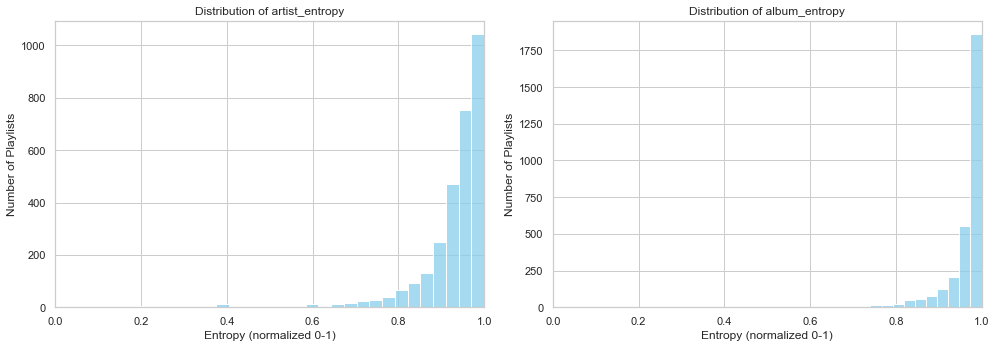

In [75]:
sns.set(style="whitegrid")

entropy_cols = ['artist_entropy', 'album_entropy']
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

for ax, col in zip(axes, entropy_cols):
    sns.histplot(df_agg[col], bins=30, ax=ax, color='skyblue')
    ax.set_title(f'Distribution of {col}')
    ax.set_xlabel('Entropy (normalized 0-1)')
    ax.set_ylabel('Number of Playlists')
    ax.set_xlim(0, 1)

plt.tight_layout()
plt.show()

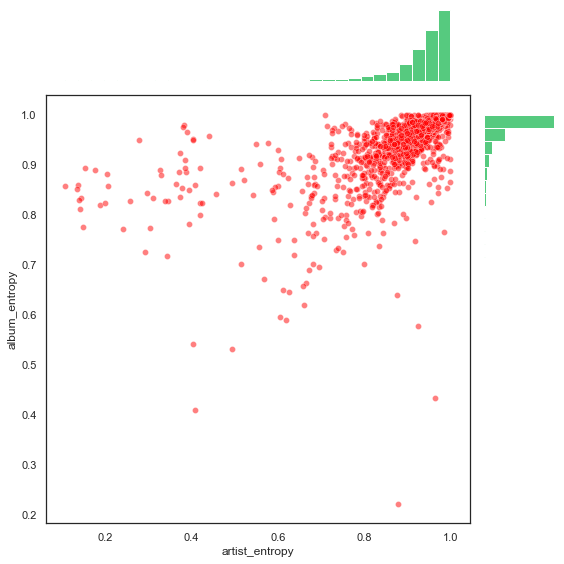

In [54]:

# Turn OFF grid globally
sns.set(style="white", rc={"axes.grid": False})

g = sns.jointplot(
    data=df_agg,
    x="artist_entropy",
    y="album_entropy",
    kind="scatter",
    color="red",
    alpha=0.5,
    marginal_kws=dict(bins=30, fill=True, color="#1DB954"),
    height=8
)

# Keep spines for joint plot (scatter)
joint_ax = g.ax_joint

for spine in ["top", "right", "left", "bottom"]:
    joint_ax.spines[spine].set_visible(True)

# Remove spines for marginal plots only
for ax in [g.ax_marg_x, g.ax_marg_y]:
    for spine in ["top", "right", "left", "bottom"]:
        ax.spines[spine].set_visible(False)

plt.show()

**First observations**

From the above, we can already observe that artist and album entropy is high in the extracted dataset, suggesting that playlists contain tracks from a wide variety of artists and albums in most cases. 

# Investigate Extras data

In [23]:
extras['top_artists'][0]

[('Jesse McCartney', 4),
 ('Chris Brown', 3),
 ('Justin Bieber', 3),
 ('Ne-Yo', 2),
 ('Beyoncé', 2)]

In [24]:
# Flatten top_artists into a long table
records = []
for pid, artist_list in extras['top_artists'].items():
    for rank, (artist_name, count) in enumerate(artist_list, start=1):
        records.append({
            "pid": pid,
            "artist_name": artist_name,
            "count_in_playlist": count,
            "rank_in_playlist": rank
        })
df_top_artists = pd.DataFrame(records)

**Investigate artist-artist co-occurence**

In [25]:
pair_counts = Counter()

for pid, group in df_top_artists.groupby("pid"):
    artists = sorted(set(group["artist_name"].dropna()))
    for a, b in combinations(artists, 2):
        pair_counts[(a, b)] += 1

df_artist_pairs = (
    pd.DataFrame(
        [
            {"artist_a": a, "artist_b": b, "num_playlists_together": cnt}
            for (a, b), cnt in pair_counts.items()
        ]
    )
    .sort_values("num_playlists_together", ascending=False)
)

In [26]:
df_artist_pairs

,artist_a,artist_b,num_playlists_together
593,Drake,Kanye West,51
594,Drake,Kendrick Lamar,46
3137,Drake,Future,39
2035,Drake,The Weeknd,33
1174,Drake,Rihanna,31
...,...,...,...
8981,James Blake,Janelle Monáe,1
8980,Dj Bitman,Trüby Trio,1
8979,Dj Bitman,Janelle Monáe,1
8978,Dj Bitman,James Blake,1


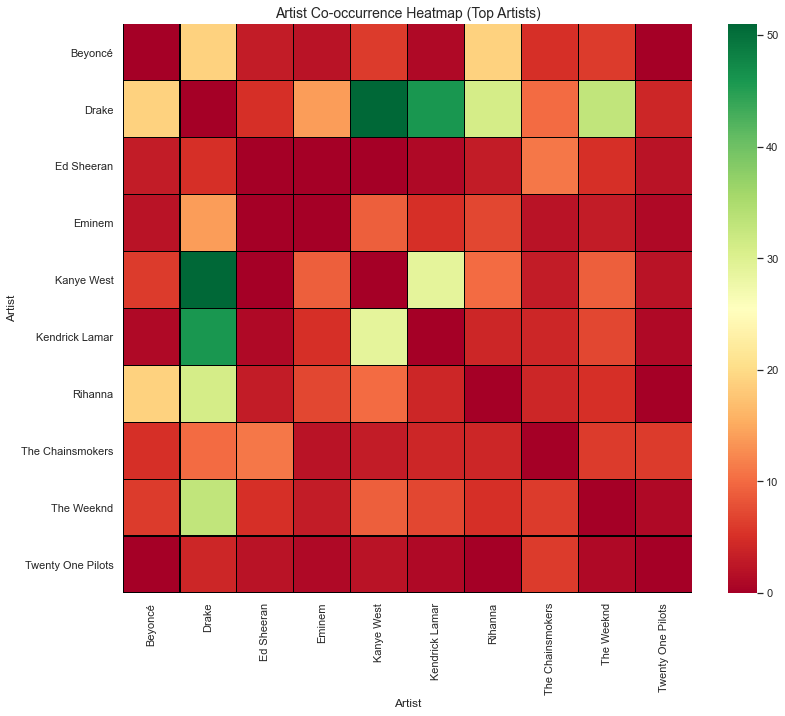

In [27]:
import seaborn as sns
import numpy as np


# Get top 10 artists by total co-occurrence
top_artists = pd.Series(df_artist_pairs["artist_a"]
                        .tolist() + df_artist_pairs["artist_b"].tolist()
                           ).value_counts().head(10).index.tolist()

# Filter to those pairs
mask = df_artist_pairs["artist_a"].isin(top_artists) & df_artist_pairs["artist_b"].isin(top_artists)
df_pairs_small = df_artist_pairs[mask]

# Build matrix
artists_sorted = sorted(top_artists)
matrix = pd.DataFrame(0, index=artists_sorted, columns=artists_sorted, dtype=int) 

for _, row in df_pairs_small.iterrows():
    a, b, w = row["artist_a"], row["artist_b"], row["num_playlists_together"]
    matrix.loc[a, b] = w #diagonal will stay 0 to not disrupt the outcome (we want to show significant co-occurences and not those created by construction)
    matrix.loc[b, a] = w

plt.figure(figsize=(12, 10))

sns.heatmap(
    matrix,
    cmap="RdYlGn",        
    linewidths=0.2,       # thin gridlines 
    linecolor="black",    # makes cells clearer
    square=True
)

plt.title("Artist Co-occurrence Heatmap (Top Artists)", fontsize=14)
plt.xlabel("Artist", fontsize=12)
plt.ylabel("Artist", fontsize=12)
plt.tight_layout()
plt.show()

In [28]:
# Merge top artists with playlist-level entropies
df_artist_playlists = (df_top_artists
    .merge(
        df_agg[["artist_entropy", "album_entropy"]],
        left_on="pid",
        right_index=True,
        how="left",
    )
)

# Aggregate per artist
df_artist_summary = (
    df_artist_playlists
    .groupby("artist_name")
    .agg(
        n_playlists=("pid", "nunique"),
        avg_rank=("rank_in_playlist", "mean"),
        avg_artist_entropy=("artist_entropy", "mean"),
        avg_album_entropy=("album_entropy", "mean"),
    )
    .sort_values("n_playlists", ascending=False)
)


In [29]:
df_artist_summary.head()

,n_playlists,avg_rank,avg_artist_entropy,avg_album_entropy
artist_name,,,,
Drake,291,2.171821,0.919747,0.966249
Kanye West,130,2.853846,0.923013,0.968436
Kendrick Lamar,116,2.775862,0.922390,0.967590
Rihanna,106,2.839623,0.936865,0.978947
Ed Sheeran,100,2.590000,0.934863,0.971220


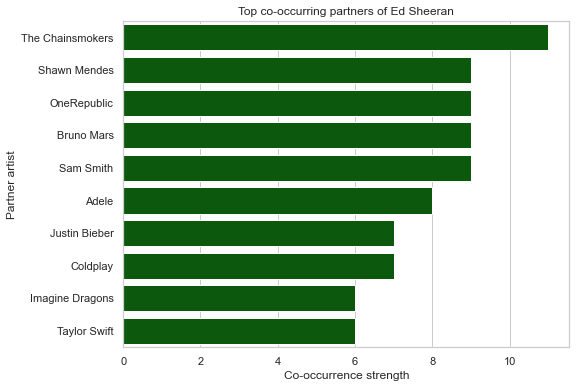

In [30]:
df_pairs_long = pd.concat([
    df_artist_pairs.rename(columns={"artist_a": "artist", "artist_b": "partner"}),
    df_artist_pairs.rename(columns={"artist_b": "artist", "artist_a": "partner"})
], ignore_index=True)

df_artist_co_stats = (
    df_pairs_long
    .groupby("artist")
    .agg(
        num_distinct_partners=("partner", "nunique"),
        total_pair_strength=("num_playlists_together", "sum"),
        strongest_single_pair=("num_playlists_together", "max")
    )
    .sort_values("total_pair_strength", ascending=False)
)


#Focus on specific artists
target_artist = "Ed Sheeran"   # example — replace with any artist name

df_drake_partners = (
    df_pairs_long
    .query("artist == @target_artist")
    .sort_values("num_playlists_together", ascending=False)
)

df_drake_partners.head()
plt.figure(figsize=(8,6))
sns.barplot(
    data=df_drake_partners.head(10),
    x="num_playlists_together",
    y="partner",
    color="darkgreen"
)
plt.title(f"Top co-occurring partners of {target_artist}")
plt.xlabel("Co-occurrence strength")
plt.ylabel("Partner artist")
plt.show()

# Question 3 - similarity between tracks

In [69]:
df_full_enriched.head(100).to_excel("head.xlsx")

<ipython-input-69-a2f092058926>:1: UserWarning: Pandas requires version '1.4.3' or newer of 'xlsxwriter' (version '1.3.8' currently installed).
  df_full_enriched.head(100).to_excel("head.xlsx")


In [87]:
# ------------------------------------------------------------------
# Build a simple track feature table including genre
# ------------------------------------------------------------------

df_track_features = (
    df_full_enriched
    .dropna(subset=["track_uri"])
    .drop_duplicates(subset=["track_uri"])
    [["track_uri", "artist_uri", "album_uri", "duration_ms_track",
      "track_name", "artist_name", "album_name", "genre"]]   # <-- CHANGED HERE
    .set_index("track_uri")
)

# Convert genre strings into clean lists
df_track_features["genre"] = (
    df_track_features["genre"]
    .fillna("")
    .apply(lambda g: [x.strip().lower() for x in g.split(",") if x.strip()])
)

def _get_track_info(track_id: str):
    return df_track_features.loc[track_id]

def genre_similarity(genres1, genres2):
    """
    Jaccard similarity over genre lists.
    Returns None if either has no genre, so genre is ignored.
    """
    if not genres1 or not genres2:
        return None

    set1, set2 = set(genres1), set(genres2)
    inter = len(set1 & set2)
    union = len(set1 | set2)

    if union == 0:
        return None

    return inter / union

import numpy as np

def metadata_similarity(track_id_1: str,
                        track_id_2: str,
                        max_duration_diff_sec: float = 150.0) -> float:

    if track_id_1 == track_id_2:
        return 1.0

    try:
        t1 = _get_track_info(track_id_1)
        t2 = _get_track_info(track_id_2)
    except KeyError:
        return 0.0

    # Artist and album match
    same_artist = 1.0 if t1["artist_uri"] == t2["artist_uri"] else 0.0
    same_album  = 1.0 if t1["album_uri"]  == t2["album_uri"]  else 0.0

    # Duration similarity (smooth exponential)
    d1 = (t1["duration_ms_track"] or 0) / 1000.0
    d2 = (t2["duration_ms_track"] or 0) / 1000.0
    diff = abs(d1 - d2)
    duration_closeness = float(np.exp(-diff / max_duration_diff_sec))

    # GENRE similarity from 'genre' column
    s_genre = genre_similarity(t1["genre"], t2["genre"])

    # Base weights
    weights = {
        "genre": 0.40,
        "artist": 0.30,
        "album": 0.15,
        "duration": 0.15,
    }

    # If genre missing, remove weight and renormalize
    if s_genre is None:
        del weights["genre"]
        total = sum(weights.values())
        for k in weights:
            weights[k] /= total

    # Combine components
    sim = (
        (weights.get("genre", 0) * (s_genre if s_genre is not None else 0)) +
        (weights["artist"] * same_artist) +
        (weights["album"] * same_album) +
        (weights["duration"] * duration_closeness)
    )

    return float(max(0.0, min(1.0, sim)))



In [89]:
track_to_playlists = defaultdict(set)

for _, row in df_full[["track_uri", "pid"]].dropna(subset=["track_uri"]).iterrows():
    track_to_playlists[row["track_uri"]].add(row["pid"])

TOTAL_PLAYLISTS = len(df_full["pid"].unique())


def collaborative_similarity(track_id_1: str, track_id_2: str) -> float:
    """
    Collaborative similarity using normalized PMI.
    """
    if track_id_1 == track_id_2:
        return 1.0

    P1 = track_to_playlists.get(track_id_1, set())
    P2 = track_to_playlists.get(track_id_2, set())

    if not P1 or not P2:
        return 0.0

    inter = len(P1 & P2)
    if inter == 0:
        return 0.0

    p_ab = inter / TOTAL_PLAYLISTS
    p_a = len(P1) / TOTAL_PLAYLISTS
    p_b = len(P2) / TOTAL_PLAYLISTS

    pmi = math.log(p_ab / (p_a * p_b))

    sim = 1 / (1 + math.exp(-pmi))
    return float(sim)


In [90]:
def track_similarity(track_id_1: str,
                     track_id_2: str,
                     alpha: float = 0.55) -> float:
    """
    Final similarity combining metadata + PMI collaborative similarity.
    """
    s_meta = metadata_similarity(track_id_1, track_id_2)
    s_collab = collaborative_similarity(track_id_1, track_id_2)

    sim = alpha * s_meta + (1 - alpha) * s_collab
    return float(max(0.0, min(1.0, sim)))

In [92]:
subset_track_ids = df_track_features.index[:20].tolist()

similarity_matrix = pd.DataFrame(index=subset_track_ids,
                                 columns=subset_track_ids,
                                 dtype=float)

for t1 in subset_track_ids:
    for t2 in subset_track_ids:
        similarity_matrix.loc[t1, t2] = track_similarity(t1, t2)

labels = (df_track_features["track_name"] + " — " + df_track_features["artist_name"]).to_dict()
similarity_matrix = similarity_matrix.rename(index=labels, columns=labels)

similarity_matrix.to_excel("sim_matrix.xlsx")
similarity_matrix.head()

<ipython-input-92-dc321961d0b6>:14: UserWarning: Pandas requires version '1.4.3' or newer of 'xlsxwriter' (version '1.3.8' currently installed).
  similarity_matrix.to_excel("sim_matrix.xlsx")


,Lose Control (feat. Ciara & Fat Man Scoop) — Missy Elliott,Toxic — Britney Spears,Crazy In Love — Beyoncé,Rock Your Body — Justin Timberlake,It Wasn't Me — Shaggy,Yeah! — Usher,My Boo — Usher,Buttons — The Pussycat Dolls,Say My Name — Destiny's Child,Hey Ya! - Radio Mix / Club Mix — OutKast,Promiscuous — Nelly Furtado,Right Where You Want Me - Radio Edit Version — Jesse McCartney,Beautiful Soul — Jesse McCartney,Leavin' — Jesse McCartney,Me & U — Cassie,Ice Box — Omarion,Sk8er Boi — Avril Lavigne,Run It! — Chris Brown,Check On It - feat. Bun B and Slim Thug — Beyoncé,"Jumpin', Jumpin' — Destiny's Child"
Lose Control (feat. Ciara & Fat Man Scoop) — Missy Elliott,1.000000,0.544908,0.560673,0.699301,0.554653,0.536548,0.723969,0.738680,0.529777,0.560500,0.726297,0.563727,0.543830,0.710032,0.696067,0.547267,0.546633,0.740318,0.550196,0.571368
Toxic — Britney Spears,0.544908,1.000000,0.533877,0.513449,0.509723,0.501415,0.474097,0.553447,0.508643,0.505836,0.524576,0.565342,0.540665,0.551994,0.553819,0.512634,0.540875,0.534005,0.553561,0.491276
Crazy In Love — Beyoncé,0.560673,0.533877,1.000000,0.539255,0.526429,0.543369,0.522871,0.557566,0.530075,0.556152,0.542851,0.550230,0.538825,0.540679,0.520433,0.523167,0.512621,0.559987,0.805003,0.542678
Rock Your Body — Justin Timberlake,0.699301,0.513449,0.539255,1.000000,0.528880,0.550925,0.711295,0.713096,0.557152,0.527905,0.716337,0.529293,0.499411,0.675438,0.707424,0.554859,0.520806,0.704070,0.526633,0.538017
It Wasn't Me — Shaggy,0.554653,0.509723,0.526429,0.528880,1.000000,0.530808,0.558312,0.534461,0.518751,0.538068,0.539859,0.531767,0.493886,0.505375,0.529777,0.541488,0.516301,0.563466,0.488203,0.552965


# Question 4 - Similarity between playlists

In [56]:
playlist_to_tracks = (
    df_full_enriched.groupby("pid")["track_uri"]
    .apply(set)
    .to_dict()
)
def pmi_sim(track1, track2, track_to_playlists, total_playlists):
    A = track_to_playlists[track1]
    B = track_to_playlists[track2]
    inter = len(A & B)
    if inter == 0: 
        return 0.0
    
    p_ab = inter / total_playlists
    p_a = len(A) / total_playlists
    p_b = len(B) / total_playlists

    pmi = math.log(p_ab / (p_a * p_b))
    # Normalize between 0 and 1
    return 1 / (1 + math.exp(-pmi))

def cosine_playlist_similarity(A, B):
    TA = playlist_to_tracks[A]
    TB = playlist_to_tracks[B]
    inter = len(TA & TB)
    denom = (len(TA) * len(TB)) ** 0.5
    return inter / denom if denom > 0 else 0.0
def cross_track_similarity(A, B, k=20):
    TA = list(playlist_to_tracks[A])
    TB = list(playlist_to_tracks[B])

    if not TA or not TB:
        return 0.0

    sample_A = random.sample(TA, min(k, len(TA)))
    sample_B = random.sample(TB, min(k, len(TB)))

    sims = [track_similarity(a, b) for a in sample_A for b in sample_B]
    return float(np.mean(sims))
def playlist_similarity(pid1, pid2):
    s_tracks = pmi_sim(pid1, pid2)
    s_cf     = cosine_playlist_similarity(pid1, pid2)
    s_cross  = cross_track_similarity(pid1, pid2)

    return 0.4*s_cf + 0.3*s_tracks + 0.3*s_cross


In [57]:
df_full.shape


(200773, 21)

In [58]:
from scipy.sparse import csr_matrix


# Map playlist IDs and track IDs to integer indices
playlist_ids = df_full_enriched["pid"].astype("category")
track_ids = df_full_enriched["track_uri"].astype("category")

row_idx = playlist_ids.cat.codes
col_idx = track_ids.cat.codes

# Build sparse playlist × track matrix
P = csr_matrix(
    (np.ones(len(df_full_enriched)), (row_idx, col_idx)),
    shape=(playlist_ids.cat.categories.size, track_ids.cat.categories.size)
)
# Compute similarity only among a subset of playlists, e.g. first 500
subset = P[:30]  # or use playlist_ids.cat.categories[:500]
sim_matrix = cosine_similarity(subset, dense_output=False)


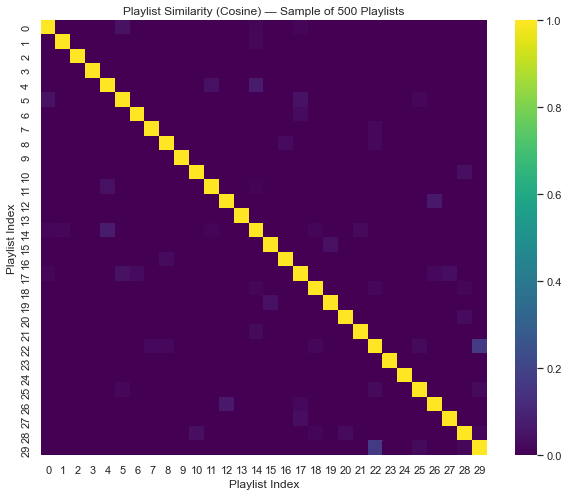

In [59]:
plt.figure(figsize=(10, 8))
sns.heatmap(sim_matrix.toarray(), cmap="viridis")
plt.title("Playlist Similarity (Cosine) — Sample of 500 Playlists")
plt.xlabel("Playlist Index")
plt.ylabel("Playlist Index")
plt.show()